<a href="https://colab.research.google.com/github/dookda/cmu_udfire_gee/blob/main/hotpred/predict_hp_lstm_gee_1y_cm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# เริ่มต้นใช้งาน GEE
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar

ee.Authenticate()
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-sakda-451407")

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [12]:
import folium

# กำหนดพื้นที่ศึกษา เชียงใหม่
# siteName = 'Mae Hong Son'
# siteName = 'Chiang Mai'
# siteName = 'Nan'
siteName = 'Uttaradit'
study_area = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', 'Thailand')).filter(ee.Filter.eq('ADM1_NAME', siteName))

# config figure height
f = folium.Figure(height=300)

# add map to figure
m = folium.Map(location=[18.9, 99.0], zoom_start=7).add_to(f)

# add study area to map
folium.GeoJson(study_area.getInfo()).add_to(m)

m

กำลังเปรียบเทียบเกณฑ์การกรอง hotspot ต่างๆ...

ประมวลผลเกณฑ์: All Hotspots (T21 > 0)
จำนวนภาพ FIRMS ดิบ: 3170
ใช้เกณฑ์: ทุกจุดความร้อน (T21 > 0)
จำนวนเดือนทั้งหมด: 108
  รวม hotspot: 25,898 จุด

ประมวลผลเกณฑ์: Low-Moderate (300-320K)
จำนวนภาพ FIRMS ดิบ: 3170
ใช้เกณฑ์อุณหภูมิ: 300K ≤ T21 < 320K
จำนวนเดือนทั้งหมด: 108
  รวม hotspot: 13,760 จุด

ประมวลผลเกณฑ์: Moderate (310-320K)
จำนวนภาพ FIRMS ดิบ: 3170
ใช้เกณฑ์อุณหภูมิ: 310K ≤ T21 < 320K
จำนวนเดือนทั้งหมด: 108
  รวม hotspot: 10,600 จุด

ประมวลผลเกณฑ์: High (320K+)
จำนวนภาพ FIRMS ดิบ: 3170
ใช้เกณฑ์อุณหภูมิ: 320K ≤ T21 < 400K
จำนวนเดือนทั้งหมด: 108
  รวม hotspot: 12,138 จุด

สรุปการเปรียบเทียบเกณฑ์การกรอง hotspot
All Hotspots (T21 > 0): 25,898 จุด (100.0%)


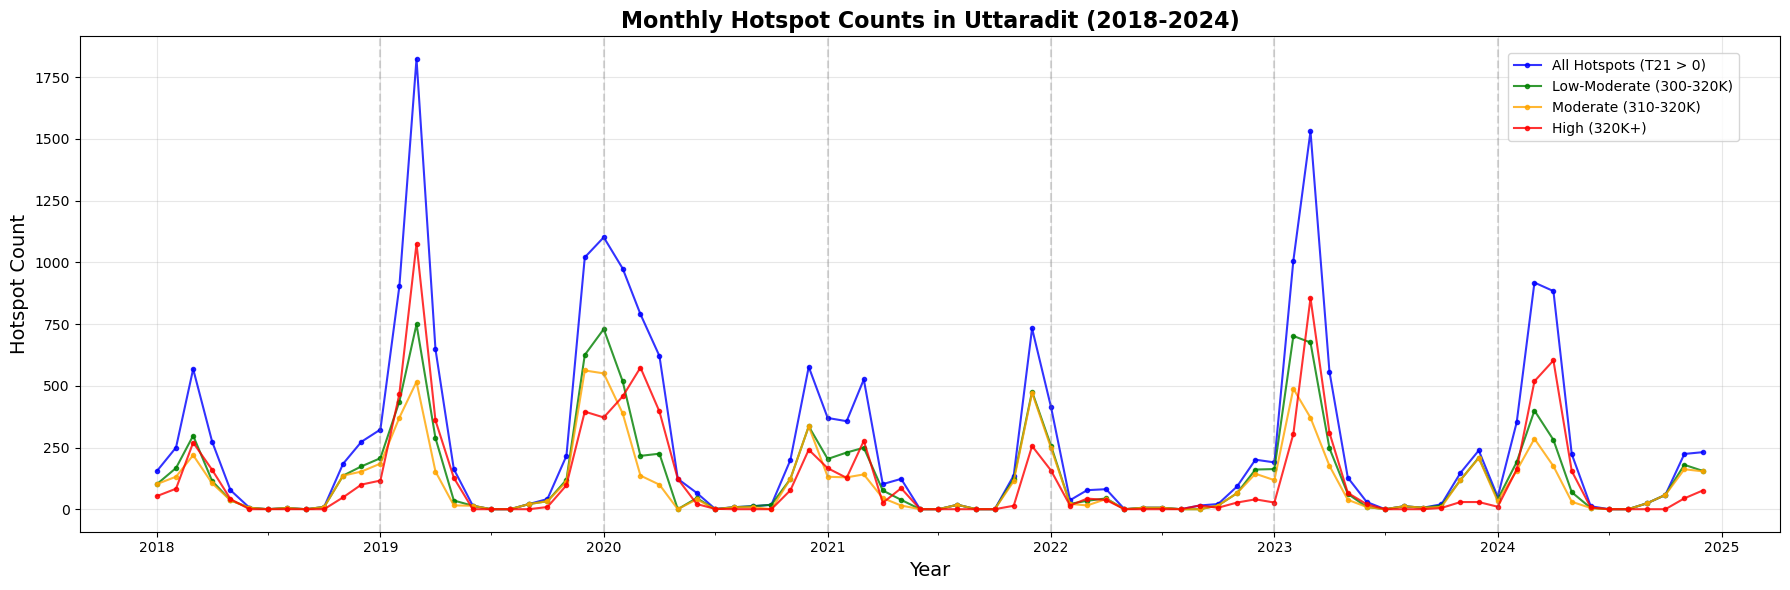

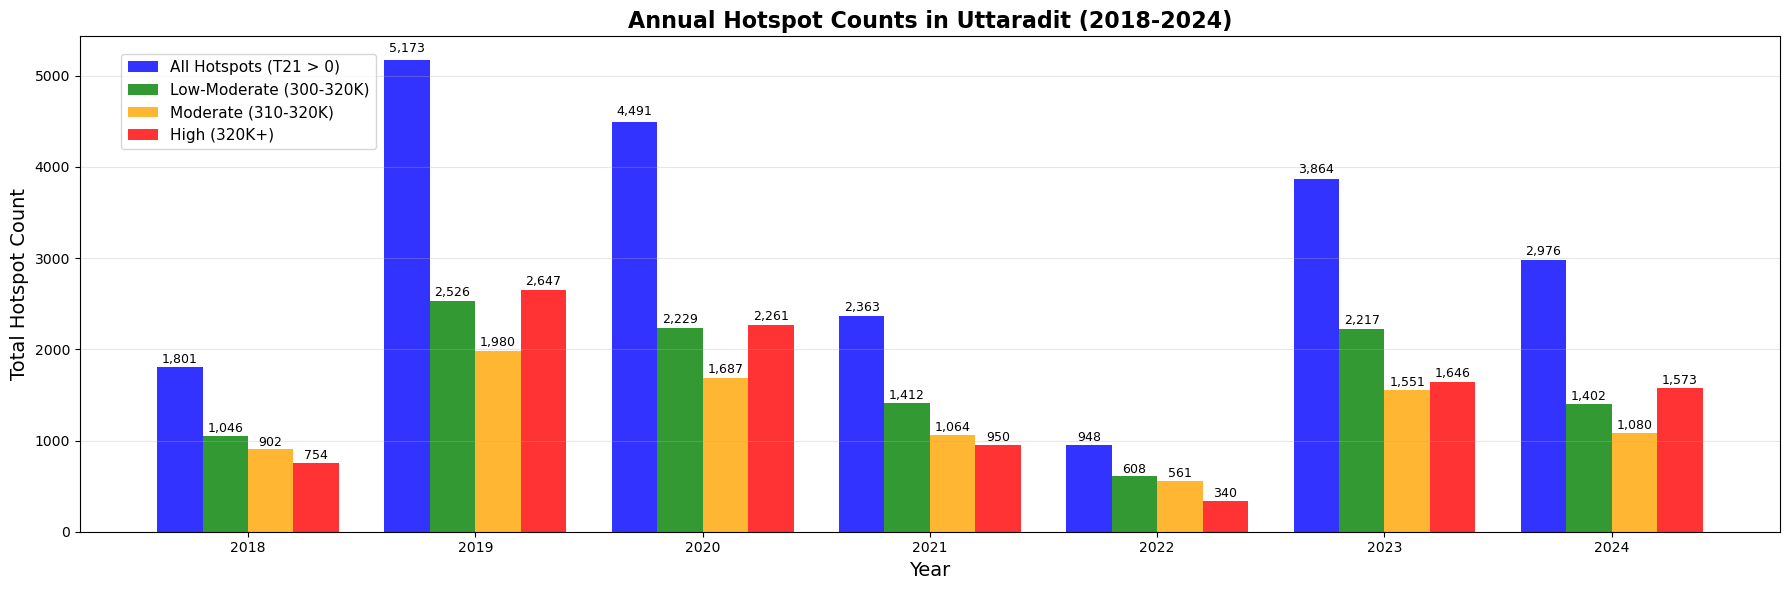


สรุปจำนวน Hotspot รายปีใน Uttaradit
Year  All Hotspots (T   Low-Moderate (3   Moderate (310-3   High (320K+)      
--------------------------------------------------------------------------------
2018  1,801             1,047             902               755               
2019  5,174             2,527             1,981             2,647             
2020  4,492             2,230             1,688             2,262             
2021  2,364             1,413             1,064             951               
2022  949               609               561               340               
2023  3,865             2,218             1,552             1,647             
2024  2,976             1,403             1,081             1,573             

สถิติและแนวโน้ม
All Hotspots (T21 > 0):
  ค่าเฉลี่ย: 3,089 จุด/ปี
  แนวโน้ม: เพิ่มขึ้น (+65.2% จาก 2018 ถึง 2024)
  ปีที่มีมากที่สุด: 2019 (5,174 จุด)
  ปีที่มีน้อยที่สุด: 2022 (949 จุด)

Low-Moderate (300-320K):
  ค่าเฉลี่ย: 1,635 จุด/ปี
  แนวโน้ม:

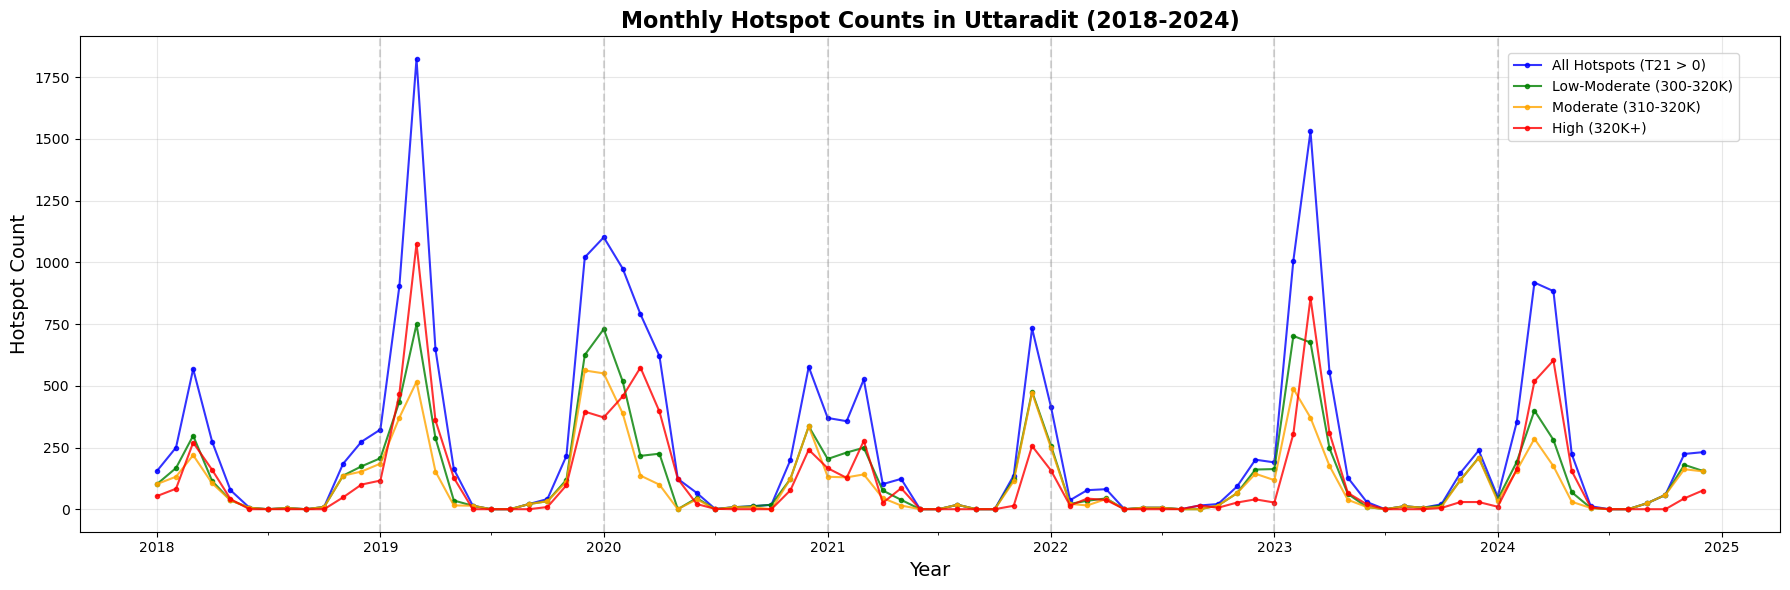

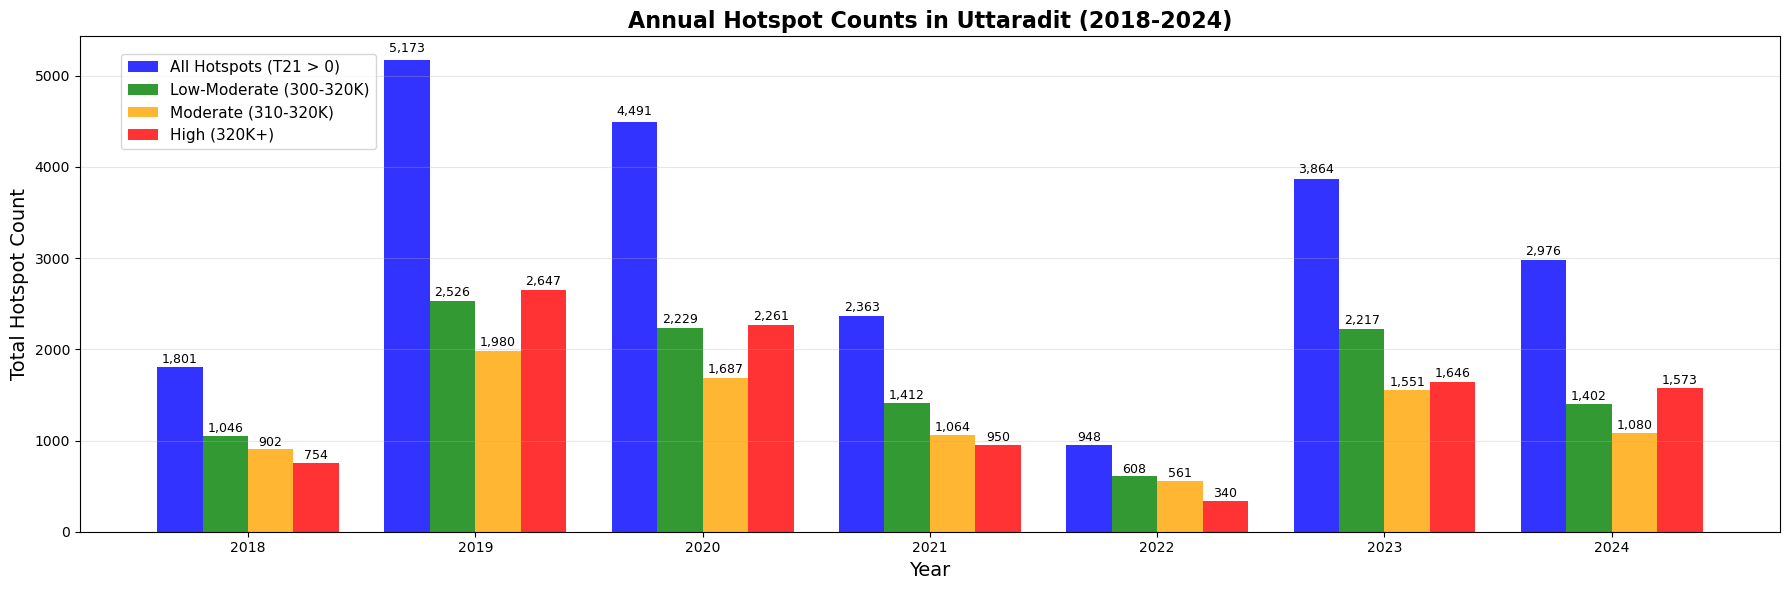


สรุปจำนวน Hotspot รายปีใน Uttaradit
Year  All Hotspots (T   Low-Moderate (3   Moderate (310-3   High (320K+)      
--------------------------------------------------------------------------------
2018  1,801             1,047             902               755               
2019  5,174             2,527             1,981             2,647             
2020  4,492             2,230             1,688             2,262             
2021  2,364             1,413             1,064             951               
2022  949               609               561               340               
2023  3,865             2,218             1,552             1,647             
2024  2,976             1,403             1,081             1,573             

สถิติและแนวโน้ม
All Hotspots (T21 > 0):
  ค่าเฉลี่ย: 3,089 จุด/ปี
  แนวโน้ม: เพิ่มขึ้น (+65.2% จาก 2018 ถึง 2024)
  ปีที่มีมากที่สุด: 2019 (5,174 จุด)
  ปีที่มีน้อยที่สุด: 2022 (949 จุด)

Low-Moderate (300-320K):
  ค่าเฉลี่ย: 1,635 จุด/ปี
  แนวโน้ม:

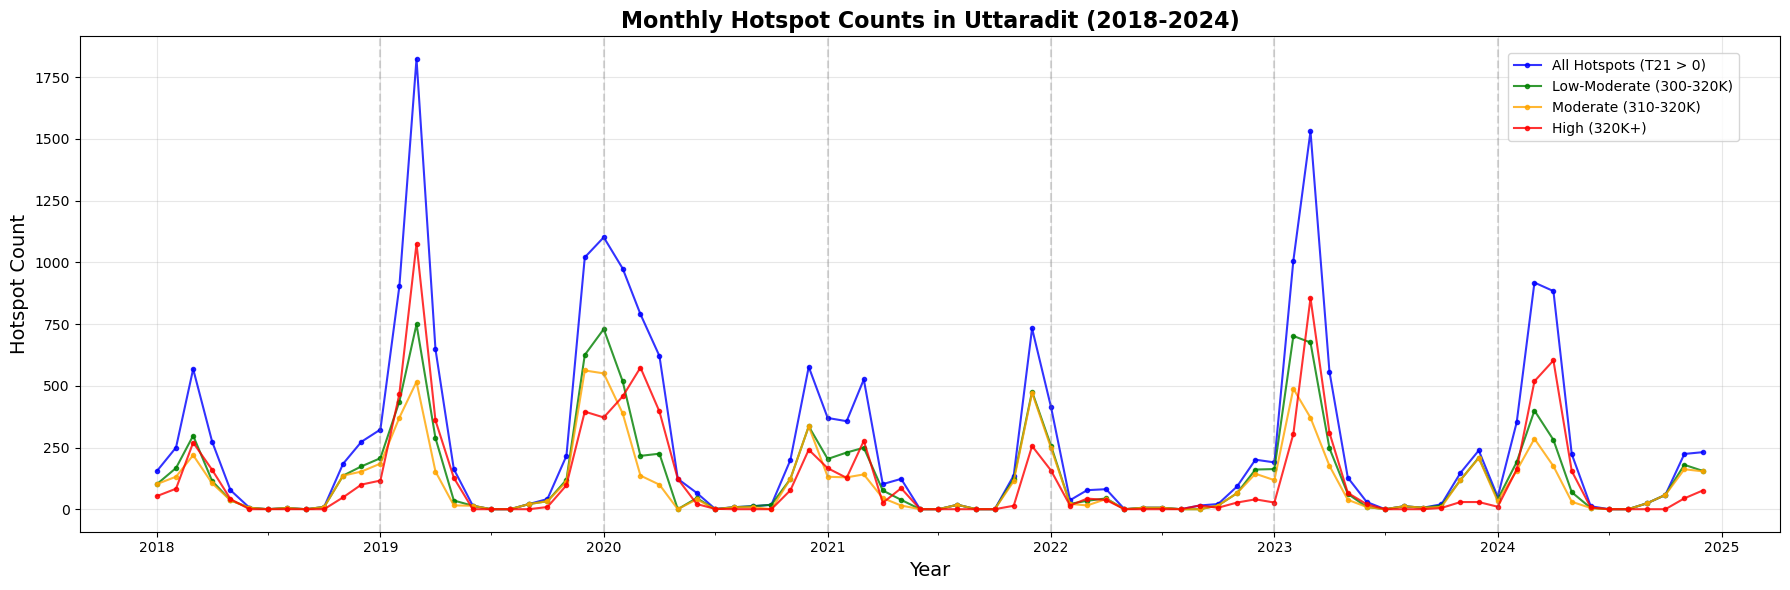

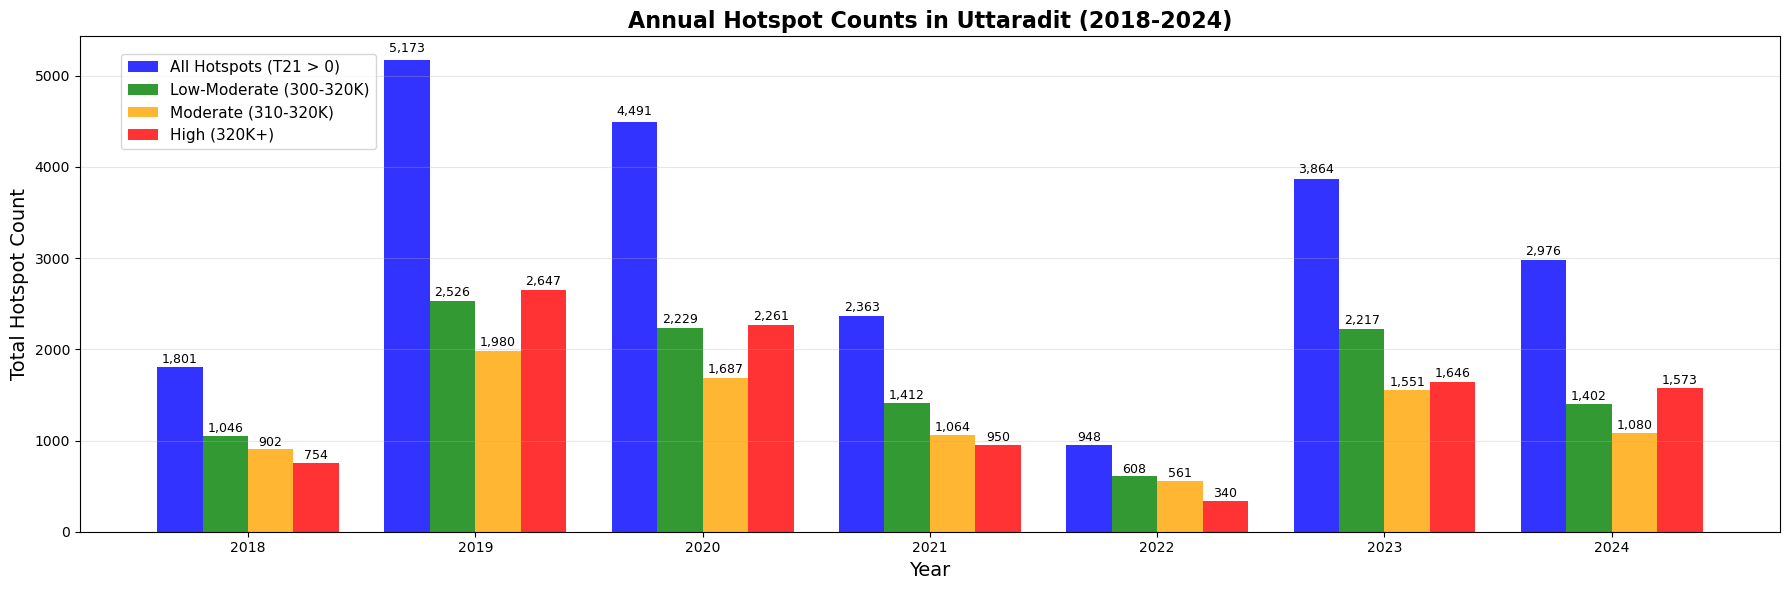


สรุปจำนวน Hotspot รายปีใน Uttaradit
Year  All Hotspots (T   Low-Moderate (3   Moderate (310-3   High (320K+)      
--------------------------------------------------------------------------------
2018  1,801             1,047             902               755               
2019  5,174             2,527             1,981             2,647             
2020  4,492             2,230             1,688             2,262             
2021  2,364             1,413             1,064             951               
2022  949               609               561               340               
2023  3,865             2,218             1,552             1,647             
2024  2,976             1,403             1,081             1,573             

สถิติและแนวโน้ม
All Hotspots (T21 > 0):
  ค่าเฉลี่ย: 3,089 จุด/ปี
  แนวโน้ม: เพิ่มขึ้น (+65.2% จาก 2018 ถึง 2024)
  ปีที่มีมากที่สุด: 2019 (5,174 จุด)
  ปีที่มีน้อยที่สุด: 2022 (949 จุด)

Low-Moderate (300-320K):
  ค่าเฉลี่ย: 1,635 จุด/ปี
  แนวโน้ม:

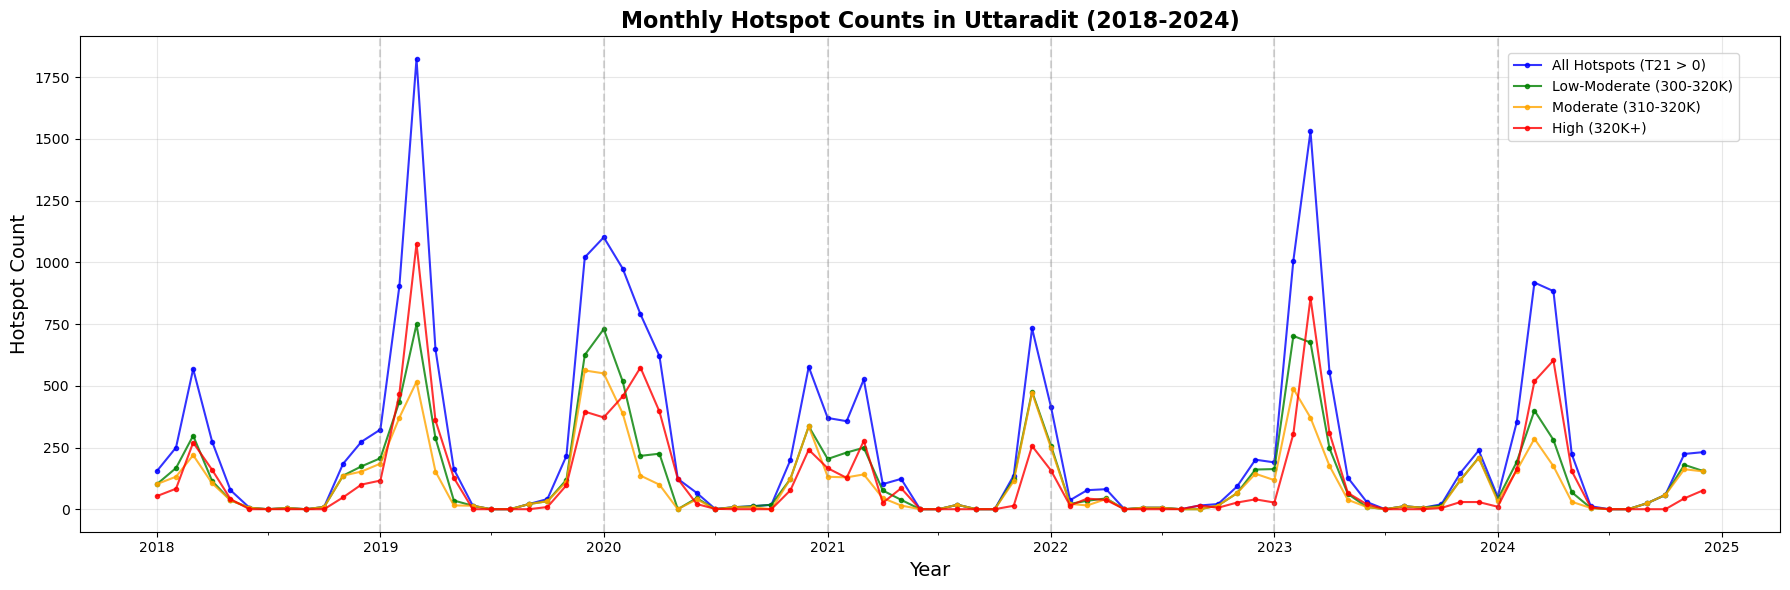

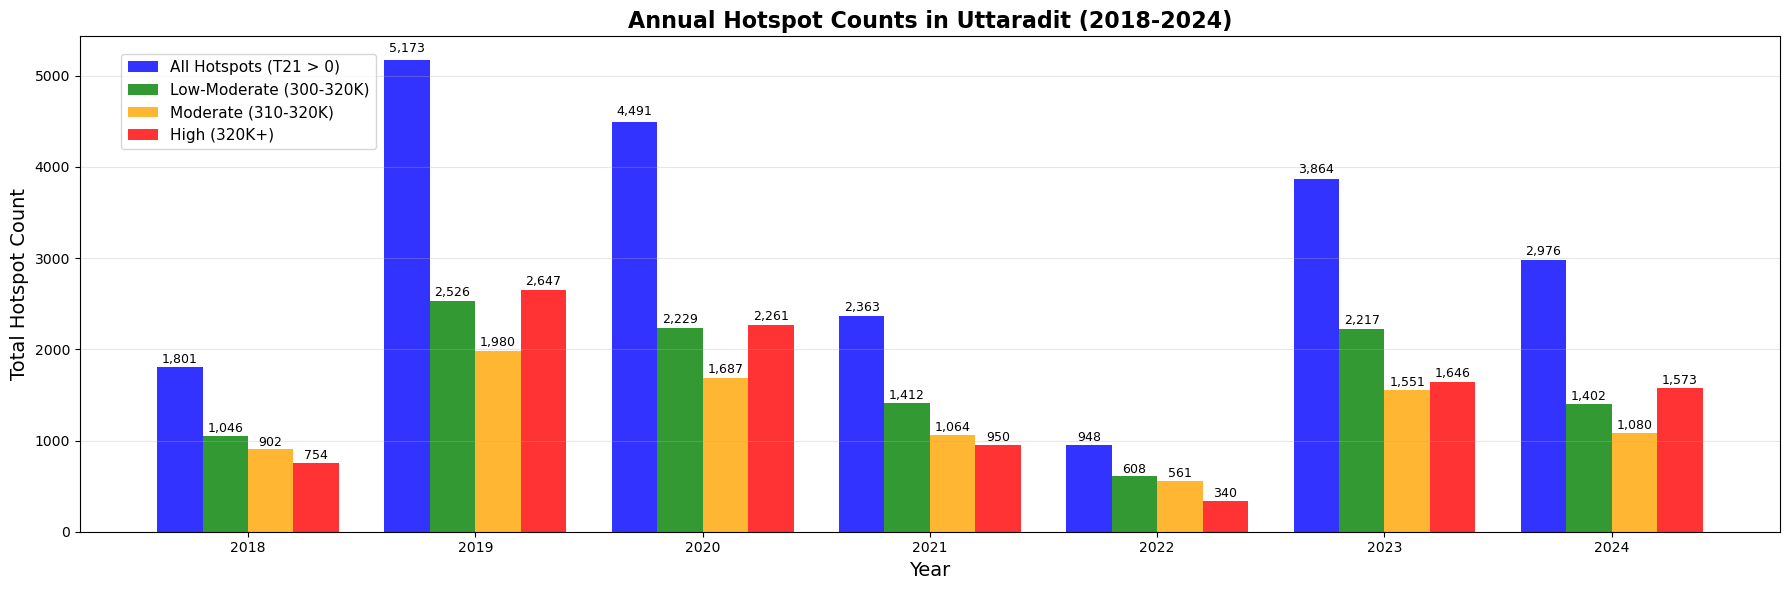


สรุปจำนวน Hotspot รายปีใน Uttaradit
Year  All Hotspots (T   Low-Moderate (3   Moderate (310-3   High (320K+)      
--------------------------------------------------------------------------------
2018  1,801             1,047             902               755               
2019  5,174             2,527             1,981             2,647             
2020  4,492             2,230             1,688             2,262             
2021  2,364             1,413             1,064             951               
2022  949               609               561               340               
2023  3,865             2,218             1,552             1,647             
2024  2,976             1,403             1,081             1,573             

สถิติและแนวโน้ม
All Hotspots (T21 > 0):
  ค่าเฉลี่ย: 3,089 จุด/ปี
  แนวโน้ม: เพิ่มขึ้น (+65.2% จาก 2018 ถึง 2024)
  ปีที่มีมากที่สุด: 2019 (5,174 จุด)
  ปีที่มีน้อยที่สุด: 2022 (949 จุด)

Low-Moderate (300-320K):
  ค่าเฉลี่ย: 1,635 จุด/ปี
  แนวโน้ม:

In [ ]:
import ee
import folium
import pandas as pd
import matplotlib.pyplot as plt

# ฟังก์ชันดึงข้อมูล Hotspot รายเดือนจาก FIRMS
def get_monthly_hotspots(start_date, end_date, study_area, temp_min=310, temp_max=320, all_hotspots=False):
    """
    ดึงข้อมูล hotspot รายเดือนด้วยการกรองอุณหภูมิ T21 ในช่วงที่กำหนด
    
    Parameters:
    - start_date, end_date: ช่วงวันที่
    - study_area: พื้นที่ศึกษา
    - temp_min: อุณหภูมิต่ำสุด (Kelvin) - default 310
    - temp_max: อุณหภูมิสูงสุด (Kelvin) - default 320
    - all_hotspots: ถ้า True ใช้เกณฑ์ T21 > 0 แทนการกรอง min-max
    """
    try:
        # เรียกชุดข้อมูล FIRMS
        firms = ee.ImageCollection('FIRMS') \
            .filterDate(start_date, end_date) \
            .filterBounds(study_area)

        # ตรวจสอบว่ามีข้อมูลหรือไม่
        size = firms.size().getInfo()
        print(f"จำนวนภาพ FIRMS ดิบ: {size}")
        if size == 0:
            print("ไม่มีข้อมูล FIRMS ในพื้นที่ศึกษา")
            return None

        if all_hotspots:
            print("ใช้เกณฑ์: ทุกจุดความร้อน (T21 > 0)")
        else:
            print(f"ใช้เกณฑ์อุณหภูมิ: {temp_min}K ≤ T21 < {temp_max}K")

        # Apply temperature filter for T21
        def convert_to_filtered_presence(image):
            t21 = image.select('T21')
            if all_hotspots:
                hotspot_presence = t21.gt(0).rename('hotspot_presence')
            else:
                hotspot_presence = t21.gte(temp_min).And(t21.lt(temp_max)).rename('hotspot_presence')
            return image.addBands(hotspot_presence).copyProperties(image, ['system:time_start'])

        firms_with_presence = firms.map(convert_to_filtered_presence)

        # รวม hotspot เป็นรายเดือน
        def create_monthly_hotspot_composite(year_month):
            year = ee.Number(year_month).divide(100).floor().int()
            month = ee.Number(year_month).mod(100).int()
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            monthly_collection = firms_with_presence.filterDate(start, end)
            count = monthly_collection.size()

            def process_with_data():
                monthly_sum = monthly_collection.select('hotspot_presence').sum()
                reduction = monthly_sum.reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=study_area,
                    scale=1000,
                    maxPixels=1e9
                )
                hotspot_count = ee.Number(reduction.get('hotspot_presence'))
                hotspot_count = ee.Algorithms.If(hotspot_count, hotspot_count, ee.Number(0))

                return ee.Image.constant(hotspot_count).toFloat().rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month) \
                    .set('temp_filter_min', temp_min) \
                    .set('temp_filter_max', temp_max) \
                    .set('hotspot_count_prop', hotspot_count)

            def process_without_data():
                return ee.Image.constant(0).toFloat().rename('hotspot_count') \
                    .set('system:time_start', start.millis()) \
                    .set('system:index', start.format('YYYY_MM')) \
                    .set('year', year) \
                    .set('month', month) \
                    .set('temp_filter_min', temp_min) \
                    .set('temp_filter_max', temp_max) \
                    .set('hotspot_count_prop', ee.Number(0))

            return ee.Algorithms.If(count.gt(0), process_with_data(), process_without_data())

        # สร้างรายการปี-เดือน
        start_year = int(start_date.split('-')[0])
        end_year = int(end_date.split('-')[0])
        year_months = []
        for year in range(start_year, end_year + 1):
            start_month = 1 if year > start_year else int(start_date.split('-')[1])
            end_month = 12 if year < end_year else int(end_date.split('-')[1])
            for month in range(start_month, end_month + 1):
                year_months.append(year * 100 + month)

        year_months_ee = ee.List(year_months)
        monthly_images = year_months_ee.map(create_monthly_hotspot_composite)
        monthly_composites = ee.ImageCollection.fromImages(monthly_images)

        total_months = monthly_composites.size().getInfo()
        print(f"จำนวนเดือนทั้งหมด: {total_months}")

        return monthly_composites.select(['hotspot_count'])
        
    except Exception as e:
        print(f"Error getting monthly hotspots: {e}")
        return None

# ฟังก์ชันเปรียบเทียบเกณฑ์ต่างๆและสร้างแผนภูมิ
def compare_hotspot_criteria_simple(start_date, end_date, study_area):
    """
    เปรียบเทียบผลลัพธ์จากเกณฑ์การกรอง T21 และสร้างแผนภูมิด้วย Matplotlib
    """
    print("กำลังเปรียบเทียบเกณฑ์การกรอง hotspot ต่างๆ...")
    
    criteria = [
        {'name': 'All_Hotspots', 'min': 0, 'max': 1000, 'desc': 'All Hotspots (T21 > 0)'},
        {'name': 'Low_Moderate', 'min': 300, 'max': 320, 'desc': 'Low-Moderate (300-320K)'},
        {'name': 'Moderate', 'min': 310, 'max': 320, 'desc': 'Moderate (310-320K)'},
        {'name': 'High', 'min': 320, 'max': 400, 'desc': 'High (320K+)'},
    ]
    
    results = {}
    
    for criterion in criteria:
        print(f"\nประมวลผลเกณฑ์: {criterion['desc']}")
        try:
            monthly_data = get_monthly_hotspots(
                start_date, end_date, study_area, 
                temp_min=criterion['min'], temp_max=criterion['max'],
                all_hotspots=(criterion['name'] == 'All_Hotspots')
            )
            
            if monthly_data is not None and monthly_data.size().getInfo() > 0:
                months = monthly_data.aggregate_array('system:index').getInfo()
                counts = [float(c) for c in monthly_data.aggregate_array('hotspot_count_prop').getInfo()]
                total = sum(counts)
                
                results[criterion['name']] = {
                    'total': int(total),
                    'description': criterion['desc'],
                    'months': months,
                    'counts': counts
                }
            else:
                results[criterion['name']] = {
                    'total': 0,
                    'description': criterion['desc'],
                    'months': [],
                    'counts': []
                }
            print(f"  รวม hotspot: {results[criterion['name']]['total']:,} จุด")
            
        except Exception as e:
            print(f"ข้อผิดพลาดในเกณฑ์ {criterion['name']}: {e}")
            results[criterion['name']] = {
                'total': 0,
                'description': criterion['desc'],
                'months': [],
                'counts': []
            }
            continue
    
    # แสดงผลสรุป
    print("\n" + "="*60)
    print("สรุปการเปรียบเทียบเกณฑ์การกรอง hotspot")
    print("="*60)
    
    baseline_total = results.get('All_Hotspots', {}).get('total', 1)
    for name, result in results.items():
        if result['total'] > 0:
            percentage = (result['total'] / baseline_total * 100) if baseline_total > 0 else 0
            print(f"{result['description']}: {result['total']:,} จุด ({percentage:.1f}%)")
        else:
            print(f"{result['description']}: ไม่พบ hotspot หรือเกิดข้อผิดพลาด")
    
    # สร้างแผนภูมิรายเดือนแต่แสดง x-axis เป็นปี
        if results and 'All_Hotspots' in results and results['All_Hotspots']['months']:
            # สร้างรายการเดือนทั้งหมดตั้งแต่ 2018-01 ถึง 2024-12
            all_months = []
            for year in range(2018, 2025):
                for month in range(1, 13):
                    if year == 2024 and month > 12:  # จำกัดถึงเดือนธันวาคม 2024
                        break
                    all_months.append(f"{year}_{month:02d}")
            
            data = {'Month': all_months}
            
            for crit in criteria:
                name = crit['name']
                counts_dict = dict(zip(results[name]['months'], results[name]['counts']) if results[name]['months'] else {})
                counts = [counts_dict.get(m, 0.0) for m in all_months]
                data[name] = counts
            
            df = pd.DataFrame(data)
            
            # แปลงเดือนเป็น datetime objects
            df['Date'] = pd.to_datetime(df['Month'], format='%Y_%m')
            
            # สร้างแผนภูมิ
            plt.figure(figsize=(18, 6))
            
            # สำหรับแต่ละเกณฑ์ วาดเส้นกราฟ
            colors = ['blue', 'green', 'orange', 'red']
            for i, crit in enumerate(criteria):
                plt.plot(df['Date'], df[crit['name']], 
                        label=crit['desc'], 
                        marker='o', 
                        markersize=3,
                        linewidth=1.5,
                        color=colors[i],
                        alpha=0.8)
            
            plt.title(f'Monthly Hotspot Counts in {siteName} (2018-2024)', fontsize=16, fontweight='bold')
            plt.xlabel('Year', fontsize=14)
            plt.ylabel('Hotspot Count', fontsize=14)
            
            # ปรับ legend ให้แสดงในตำแหน่งที่เหมาะสม
            plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=False, 
                      ncol=1, fontsize=10, bbox_to_anchor=(0.98, 0.98))
            
            plt.grid(True, alpha=0.3)
            
            # ตั้งค่า x-axis ให้แสดงเป็นปี
            import matplotlib.dates as mdates
            
            # กำหนดให้แสดงเฉพาะปี
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.YearLocator())  # แสดงเส้นหลักที่ปี
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # รูปแบบแสดงปี
            ax.xaxis.set_minor_locator(mdates.MonthLocator([1, 7]))  # เส้นย่อยที่มกราคมและกรกฎาคม
            
            # หมุน label และปรับระยะห่าง
            plt.xticks(rotation=0)  # ไม่หมุนเพราะแสดงแค่ปี
            
            # เพิ่มเส้นแนวตั้งที่เริ่มปีใหม่
            for year in range(2019, 2025):
                plt.axvline(x=pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # สร้างแผนภูมิสรุปรายปีเพิ่มเติม
            plt.figure(figsize=(18, 6))
            
            # รวมข้อมูลรายปี - เลือกเฉพาะคอลัมน์ที่เป็นตัวเลข
            df['Year'] = df['Date'].dt.year
            
            # ระบุคอลัมน์ที่ต้องการ sum (เฉพาะข้อมูล hotspot)
            numeric_columns = [crit['name'] for crit in criteria]
            yearly_data = df.groupby('Year')[numeric_columns].sum().reset_index()
            
            # สร้าง bar chart รายปี
            x = yearly_data['Year']
            width = 0.2
            multiplier = 0
            
            for i, crit in enumerate(criteria):
                offset = width * multiplier
                bars = plt.bar(x + offset, yearly_data[crit['name']], width, 
                              label=crit['desc'], color=colors[i], alpha=0.8)
                
                # เพิ่มตัวเลขบนแท่ง
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                               f'{int(height):,}', ha='center', va='bottom', fontsize=9)
                
                multiplier += 1
            
            plt.title(f'Annual Hotspot Counts in {siteName} (2018-2024)', fontsize=16, fontweight='bold')
            plt.xlabel('Year', fontsize=14)
            plt.ylabel('Total Hotspot Count', fontsize=14)
            
            # ปรับ legend ให้แสดงอย่างชัดเจน
            plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=False, 
                      fontsize=11, bbox_to_anchor=(0.02, 0.98))
            
            plt.grid(True, alpha=0.3, axis='y')
            
            # ปรับ x-axis ให้แสดงปีทั้งหมด
            plt.xticks(x + width * 1.5, x.astype(int))
            
            plt.tight_layout()
            plt.show()
            
            # สร้างตารางสรุปรายปี
            print("\n" + "="*80)
            print(f"สรุปจำนวน Hotspot รายปีใน {siteName}")
            print("="*80)
            
            # แสดงตารางข้อมูลรายปี
            yearly_summary = yearly_data.copy()
            yearly_summary = yearly_summary.round(0).astype(int)
            
            print(f"{'Year':<6}", end="")
            for crit in criteria:
                print(f"{crit['desc'][:15]:<18}", end="")
            print()
            print("-" * 80)
            
            for _, row in yearly_summary.iterrows():
                print(f"{int(row['Year']):<6}", end="")
                for crit in criteria:
                    count = row[crit['name']]
                    print(f"{count:,}".ljust(18), end="")
                print()
            
            # คำนวณค่าเฉลี่ยและแนวโน้ม
            print("\n" + "="*60)
            print("สถิติและแนวโน้ม")
            print("="*60)
            
            for crit in criteria:
                values = yearly_summary[crit['name']].values
                avg = values.mean()
                trend = "เพิ่มขึ้น" if values[-1] > values[0] else "ลดลง" if values[-1] < values[0] else "คงที่"
                change_pct = ((values[-1] - values[0]) / values[0] * 100) if values[0] != 0 else 0
                
                print(f"{crit['desc']}:")
                print(f"  ค่าเฉลี่ย: {avg:,.0f} จุด/ปี")
                print(f"  แนวโน้ม: {trend} ({change_pct:+.1f}% จาก 2018 ถึง 2024)")
                print(f"  ปีที่มีมากที่สุด: {yearly_summary.loc[yearly_summary[crit['name']].idxmax(), 'Year']} ({yearly_summary[crit['name']].max():,} จุด)")
                print(f"  ปีที่มีน้อยที่สุด: {yearly_summary.loc[yearly_summary[crit['name']].idxmin(), 'Year']} ({yearly_summary[crit['name']].min():,} จุด)")
                print()
        
        else:
            print("ไม่มีข้อมูลรายเดือนสำหรับการสร้างแผนภูมิ")

    
    return results

# เรียกใช้ฟังก์ชันเปรียบเทียบเกณฑ์ต่างๆ
if __name__ == "__main__":
    # Initialize Earth Engine
    try:
        ee.Authenticate()
        try:
            ee.Initialize(project="ee-sakda-451407")
        except Exception as e:
            ee.Authenticate()
            ee.Initialize(project="ee-sakda-451407")
        
        # กำหนดพื้นที่ศึกษา
        # siteName = 'Mae Hong Son'
        # siteName = 'Chiang Mai'
        # siteName = 'Nan'
        siteName = 'Uttaradit'
        
        study_area = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', 'Thailand')).filter(ee.Filter.eq('ADM1_NAME', siteName))

        # เรียกใช้ฟังก์ชันด้วยช่วงวันที่ 2018-2024
        compare_hotspot_criteria_simple('2017-01-01', '2025-12-31', study_area)
        
    except Exception as e:
        print(f"ไม่สามารถเชื่อมต่อ Google Earth Engine ได้: {e}")
        print("กรุณาตรวจสอบ:")
        print("   1. การติดตั้ง earthengine-api")
        print("   2. การ authenticate: ee.Authenticate()")
        print("   3. การเชื่อมต่ออินเทอร์เน็ต")